# Micronekton Lower-mesopelagic


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from IPython.display import Markdown

from seapopym.configuration.no_transport.configuration import NoTransportConfiguration
from seapopym.configuration.no_transport.parameter import (
    ForcingParameters,
    FunctionalGroups,
    KernelParameters,
    NoTransportParameters,
)
from seapopym.configuration.parameters.parameter_environment import (
    ChunkParameter,
    ClientParameter,
    EnvironmentParameter,
)
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.configuration.parameters.parameter_functional_group import (
    FunctionalGroupUnit,
    FunctionalGroupUnitMigratoryParameters,
    FunctionalGroupUnitRelationParameters,
)
from seapopym.logging.custom_logger import set_error
from seapopym.model.no_transport_model import NoTransportModel
from seapopym.standard.units import StandardUnitsLabels

set_error()

In [2]:
path_forcing = (
    "/Users/ash/Documents/Workspaces/Data/phd/cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-i_1709010880580.nc"
)
path_bio = "/Users/ash/Documents/Workspaces/Data/phd/cmems_mod_glo_bgc_my_0.083deg-lmtl_PT1D-i_1709007157635.nc"

forcing = xr.open_dataset(path_forcing)
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
display(Markdown("### Physics"))
display(forcing)
bio = xr.open_dataset(path_bio)
display(Markdown("### Biology"))
display(bio)

### Physics

<xarray.Dataset> Size: 131MB
Dimensions:              (time: 4748, depth: 3, latitude: 24, longitude: 24)
Coordinates:
  * depth                (depth) float32 12B 1.0 2.0 3.0
  * latitude             (latitude) float32 96B 22.08 22.17 22.25 ... 23.92 24.0
  * longitude            (longitude) float32 96B -159.0 -158.9 ... -157.2 -157.1
  * time                 (time) datetime64[ns] 38kB 2010-01-01 ... 2022-12-31
Data variables:
    T                    (time, depth, latitude, longitude) float32 33MB ...
    U                    (time, depth, latitude, longitude) float32 33MB ...
    V                    (time, depth, latitude, longitude) float32 33MB ...
    pelagic_layer_depth  (time, depth, latitude, longitude) float32 33MB ...
Attributes:
    Conventions:       CF-1.11
    title:             Physical forcings of global ocean low and mid trophic ...
    institution:       CLS
    source:            SEAPODYM-LMTL 3.0.0
    history:           Created on 2022-09-28
    references:        http://www.cls.fr; http://www.seapodym.eu
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  GLOBAL_MULTIYEAR_BGC_001_033
    subset:datasetId:  cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-i_202211
    subset:date:       2024-02-27T05:14:40.588Z

### Biology

<xarray.Dataset> Size: 98MB
Dimensions:       (latitude: 24, longitude: 24, time: 4748)
Coordinates:
  * latitude      (latitude) float32 96B 22.08 22.17 22.25 ... 23.83 23.92 24.0
  * longitude     (longitude) float32 96B -159.0 -158.9 -158.8 ... -157.2 -157.1
  * time          (time) datetime64[ns] 38kB 2010-01-01 ... 2022-12-31
Data variables:
    mnkc_epi      (time, latitude, longitude) float32 11MB ...
    mnkc_hmlmeso  (time, latitude, longitude) float32 11MB ...
    mnkc_lmeso    (time, latitude, longitude) float32 11MB ...
    mnkc_mlmeso   (time, latitude, longitude) float32 11MB ...
    mnkc_mumeso   (time, latitude, longitude) float32 11MB ...
    mnkc_umeso    (time, latitude, longitude) float32 11MB ...
    npp           (time, latitude, longitude) float32 11MB ...
    zeu           (time, latitude, longitude) float32 11MB ...
    zooc          (time, latitude, longitude) float32 11MB ...
Attributes:
    Conventions:       CF-1.11
    title:             Global ocean low and mid trophic levels biomass conten...
    institution:       CLS
    source:            SEAPODYM-LMTL 3.0.0
    history:           Created on 2022-09-28
    references:        http://www.cls.fr; http://www.seapodym.eu
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  GLOBAL_MULTIYEAR_BGC_001_033
    subset:datasetId:  cmems_mod_glo_bgc_my_0.083deg-lmtl_PT1D-i_202211
    subset:date:       2024-02-27T04:12:37.642Z

## Initialize the model


In [4]:
tr_max = 527
tr_rate = -0.125
inv_lambda_max = 2109
inv_lambda_rate = 0.125
global_energy_coef = 0.0042
functional_type = FunctionalGroupUnitRelationParameters(
    inv_lambda_max=inv_lambda_max,
    inv_lambda_rate=inv_lambda_rate,
    temperature_recruitment_rate=tr_rate,
    cohorts_timesteps=[1] * np.ceil(tr_max).astype(int),
    temperature_recruitment_max=tr_max,
)
lower_mesopelagic = FunctionalGroupUnit(
    name="lower_mesopelagic",
    migratory_type=FunctionalGroupUnitMigratoryParameters(day_layer=3, night_layer=3),
    functional_type=functional_type,
    energy_transfert=global_energy_coef * 0.18,
)

f_groups = FunctionalGroups(functional_groups=[lower_mesopelagic])
p_param = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["T"], resolution=0.08333),
    primary_production=ForcingUnit(forcing=bio["npp"], resolution=0.08333),
)
parameters = NoTransportParameters(
    functional_groups_parameters=f_groups,
    forcing_parameters=p_param,
    environment_parameters=EnvironmentParameter(
        chunk=ChunkParameter(functional_group=1, latitude=6, longitude=6),
        client=ClientParameter(n_workers=2, threads_per_worker=1, memory_limit="6500MB"),
    ),
    kernel_parameters=KernelParameters(compute_initial_conditions=True),
)
micronekton_model = NoTransportModel(configuration=NoTransportConfiguration(parameters))

In [5]:
micronekton_model.initialize_dask()
micronekton_model.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 12.11 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49905,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 12.11 GiB
Comm: tcp://127.0.0.1:49912,Total threads: 1
Dashboard: http://127.0.0.1:49914/status,Memory: 6.05 GiB
Nanny: tcp://127.0.0.1:49908,


Let's see how much memory is taking the model in the current state.


In [6]:
micronekton_model.expected_memory_usage

'The expected memory usage is 11707.66 MB.'

In [7]:
micronekton_model.run()

In [8]:
micronekton_model.state.biomass.load()

<xarray.DataArray 'biomass' (functional_group: 1, time: 4748, latitude: 24,
                             longitude: 24)> Size: 22MB
array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
...
         [0.0001748 , 0.00017524, 0.00017539, ..., 0.00018041,
          0.00018105, 0.00018003],
         [0.00017474, 0.00017535, 0.00017575, ..., 0.00018028,
          0.00018055, 0.00018059],
         [0.00017472, 0.00017551, 0.00017584, ..., 0.00018084,
          0.00018021, 0.00017994]],

        [[0.00017134, 0.00017153, 0.0001724 , ..., 0.00017538,
          0.00017555, 0.00017476],
         [0.00017246, 0.00017273, 0.00017342, ..., 0.00017559,
          0.00017513, 0.00017484],
         [0.00017295, 0.00017281, 0.00017329, ..., 0.00017626,
          0.00017548, 0.0001749 ],
         ...,
         [0.00017462, 0.00017506, 0.00017521, ..., 0.00018023,
          0.00018088, 0.00017986],
         [0.00017456, 0.00017517, 0.00017557, ..., 0.00018011,
          0.00018038, 0.00018042],
         [0.00017454, 0.00017533, 0.00017565, ..., 0.00018066,
          0.00018003, 0.00017977]]]])
Coordinates:
  * functional_group  (functional_group) int64 8B 0
  * latitude          (latitude) float32 96B 22.08 22.17 22.25 ... 23.92 24.0
  * longitude         (longitude) float32 96B -159.0 -158.9 ... -157.2 -157.1
  * time              (time) datetime64[ns] 38kB 2010-01-01 ... 2022-12-31
Attributes:
    long_name:    biomass
    units:        kilogram / meter ** 2
    description:  The biomass of the recruited individuals.

## Transform the LMTL outputs to follow Seapopym standard


In [9]:
# lmtl_mnk = bio[["mnkc_epi", "mnkc_hmlmeso", "mnkc_lmeso", "mnkc_mlmeso", "mnkc_mumeso", "mnkc_umeso"]]
lmtl_mnk = bio[["mnkc_lmeso"]]
lmtl_mnk = lmtl_mnk.pint.quantify().pint.to(StandardUnitsLabels.biomass.units).pint.dequantify()
wet_to_carbon = 1 / 11.9
with xr.set_options(keep_attrs=True):
    lmtl_mnk = lmtl_mnk * wet_to_carbon
    lmtl_mnk = lmtl_mnk.mean(("latitude", "longitude"))
lmtl_mnk

<xarray.Dataset> Size: 57kB
Dimensions:     (time: 4748)
Coordinates:
  * time        (time) datetime64[ns] 38kB 2010-01-01 2010-01-02 ... 2022-12-31
Data variables:
    mnkc_lmeso  (time) float32 19kB 0.0001628 0.0001638 ... 0.0001827 0.0001827
Attributes:
    Conventions:       CF-1.11
    title:             Global ocean low and mid trophic levels biomass conten...
    institution:       CLS
    source:            SEAPODYM-LMTL 3.0.0
    history:           Created on 2022-09-28
    references:        http://www.cls.fr; http://www.seapodym.eu
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  GLOBAL_MULTIYEAR_BGC_001_033
    subset:datasetId:  cmems_mod_glo_bgc_my_0.083deg-lmtl_PT1D-i_202211
    subset:date:       2024-02-27T04:12:37.642Z

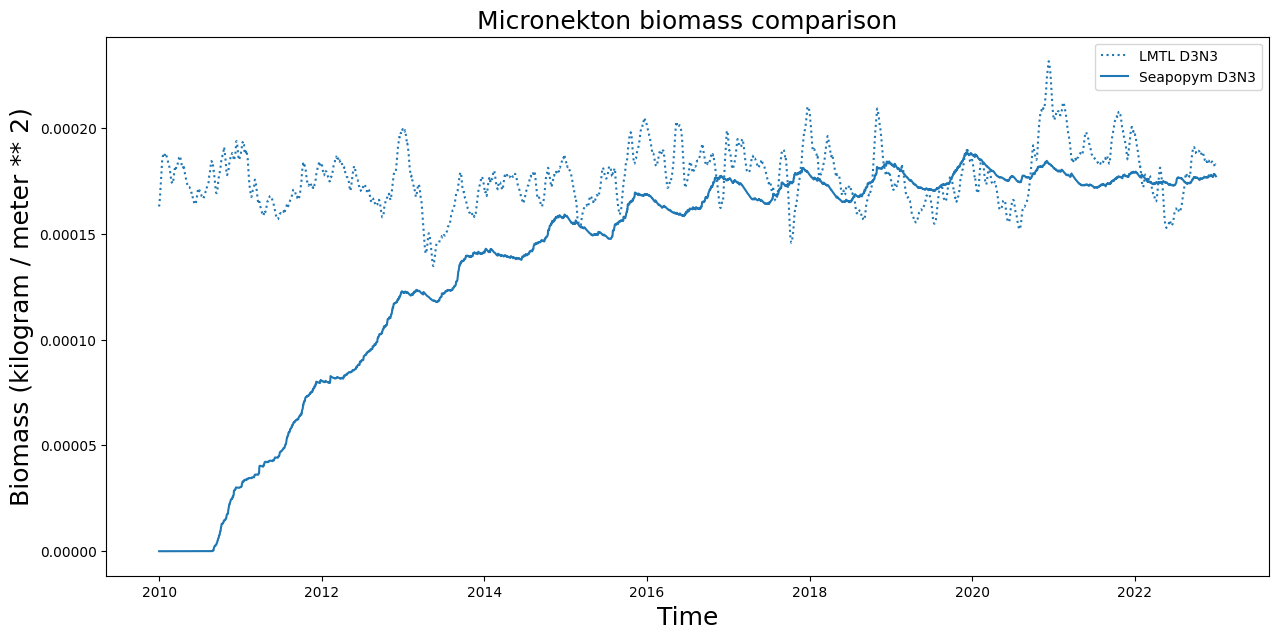

In [10]:
plt.figure(figsize=(15, 7))

color = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
lmtl_fg = ["mnkc_lmeso"]
seapopym_fg = ["lower_mesopelagic"]
names = ["D3N3"]
for i, name in enumerate(lmtl_fg):
    lmtl_mnk[name].plot.line(":", x="time", label=f"LMTL {names[i]}", color=color[i])

for i, name in enumerate(seapopym_fg):
    data = micronekton_model.state.biomass.sel(functional_group=i).cf.mean(("X", "Y"))
    data.cf.plot.line(x="time", hue="functional_group", label=f"Seapopym {names[i]}", color=color[i])
plt.legend([i.data for i in micronekton_model.state.name])

plt.legend()
plt.title("Micronekton biomass comparison", fontsize=18)
plt.ylabel(f"Biomass ({StandardUnitsLabels.biomass.units})", fontsize=18)
plt.xlabel("Time", fontsize=18)
plt.show()

---

## Let's try with initial conditions


In [13]:
initial_conditions = micronekton_model.export_initial_conditions()
initial_conditions

<xarray.Dataset> Size: 2MB
Dimensions:                       (functional_group: 1, latitude: 24,
                                   longitude: 24, cohort: 527)
Coordinates:
  * functional_group              (functional_group) int64 8B 0
  * latitude                      (latitude) float32 96B 22.08 22.17 ... 24.0
  * longitude                     (longitude) float32 96B -159.0 ... -157.1
  * cohort                        (cohort) int64 4kB 0 1 2 3 ... 523 524 525 526
    time                          datetime64[ns] 8B 2022-12-31
Data variables:
    initial_condition_production  (functional_group, latitude, longitude, cohort) float64 2MB dask.array<chunksize=(1, 6, 6, 527), meta=np.ndarray>
    initial_condition_biomass     (functional_group, latitude, longitude) float64 5kB ...

In [16]:
p_param = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["T"], resolution=0.08333),
    primary_production=ForcingUnit(forcing=bio["npp"], resolution=0.08333),
    initial_condition_biomass=ForcingUnit(forcing=initial_conditions["initial_condition_biomass"], resolution=0.08333),
    initial_condition_production=ForcingUnit(
        forcing=initial_conditions["initial_condition_production"], resolution=0.08333
    ),
)
parameters = NoTransportParameters(
    functional_groups_parameters=f_groups,
    forcing_parameters=p_param,
    environment_parameters=EnvironmentParameter(
        chunk=ChunkParameter(functional_group=1, latitude=6, longitude=6),
        client=ClientParameter(n_workers=2, threads_per_worker=1, memory_limit="6500MB"),
    ),
    kernel_parameters=KernelParameters(compute_initial_conditions=True),
)
micronekton_model_with_initial_conditions = NoTransportModel(configuration=NoTransportConfiguration(parameters))

In [17]:
micronekton_model_with_initial_conditions.initialize_dask()
micronekton_model_with_initial_conditions.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:50011/status,
Dashboard: http://127.0.0.1:50011/status,Workers: 2
Total threads: 2,Total memory: 12.11 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50012,Workers: 2
Dashboard: http://127.0.0.1:50011/status,Total threads: 2
Started: Just now,Total memory: 12.11 GiB
Comm: tcp://127.0.0.1:50021,Total threads: 1
Dashboard: http://127.0.0.1:50023/status,Memory: 6.05 GiB
Nanny: tcp://127.0.0.1:50016,


In [18]:
micronekton_model_with_initial_conditions.run()

In [19]:
micronekton_model_with_initial_conditions.state.biomass.load()

<xarray.DataArray 'biomass' (functional_group: 1, time: 4748, latitude: 24,
                             longitude: 24)> Size: 22MB
array([[[[0.0001767 , 0.00017728, 0.0001777 , ..., 0.00017742,
          0.00017745, 0.00017764],
         [0.0001769 , 0.00017787, 0.00017826, ..., 0.00017723,
          0.00017694, 0.00017734],
         [0.00017816, 0.00017835, 0.00017899, ..., 0.00017725,
          0.00017679, 0.0001773 ],
         ...,
         [0.00017621, 0.00017616, 0.00017633, ..., 0.00018006,
          0.0001807 , 0.00017968],
         [0.00017582, 0.00017626, 0.00017616, ..., 0.00017993,
          0.0001802 , 0.00018024],
         [0.00017563, 0.00017559, 0.00017546, ..., 0.00018144,
          0.00018066, 0.00018055]],

        [[0.0001765 , 0.00017708, 0.00017793, ..., 0.00017739,
          0.0001776 , 0.00017761],
         [0.00017718, 0.00017766, 0.00017833, ..., 0.0001774 ,
          0.00017711, 0.00017715],
         [0.00017823, 0.00017828, 0.00017878, ..., 0.00017725,
          0.00017698, 0.00017727],
...
         [0.00017653, 0.00017698, 0.00017714, ..., 0.00018233,
          0.00018299, 0.00018197],
         [0.00017646, 0.00017708, 0.00017749, ..., 0.0001822 ,
          0.00018248, 0.00018252],
         [0.00017643, 0.00017723, 0.00017757, ..., 0.00018275,
          0.00018212, 0.00018187]],

        [[0.00017335, 0.00017356, 0.00017443, ..., 0.00017747,
          0.00017764, 0.00017685],
         [0.00017446, 0.00017475, 0.00017544, ..., 0.00017766,
          0.0001772 , 0.00017692],
         [0.00017494, 0.00017481, 0.00017529, ..., 0.00017831,
          0.00017755, 0.00017696],
         ...,
         [0.00017635, 0.00017679, 0.00017696, ..., 0.00018216,
          0.00018281, 0.0001818 ],
         [0.00017628, 0.0001769 , 0.00017731, ..., 0.00018202,
          0.0001823 , 0.00018234],
         [0.00017625, 0.00017705, 0.00017738, ..., 0.00018257,
          0.00018195, 0.00018169]]]])
Coordinates:
  * functional_group  (functional_group) int64 8B 0
  * latitude          (latitude) float32 96B 22.08 22.17 22.25 ... 23.92 24.0
  * longitude         (longitude) float32 96B -159.0 -158.9 ... -157.2 -157.1
  * time              (time) datetime64[ns] 38kB 2010-01-01 ... 2022-12-31
Attributes:
    long_name:    biomass
    units:        kilogram / meter ** 2
    description:  The biomass of the recruited individuals.

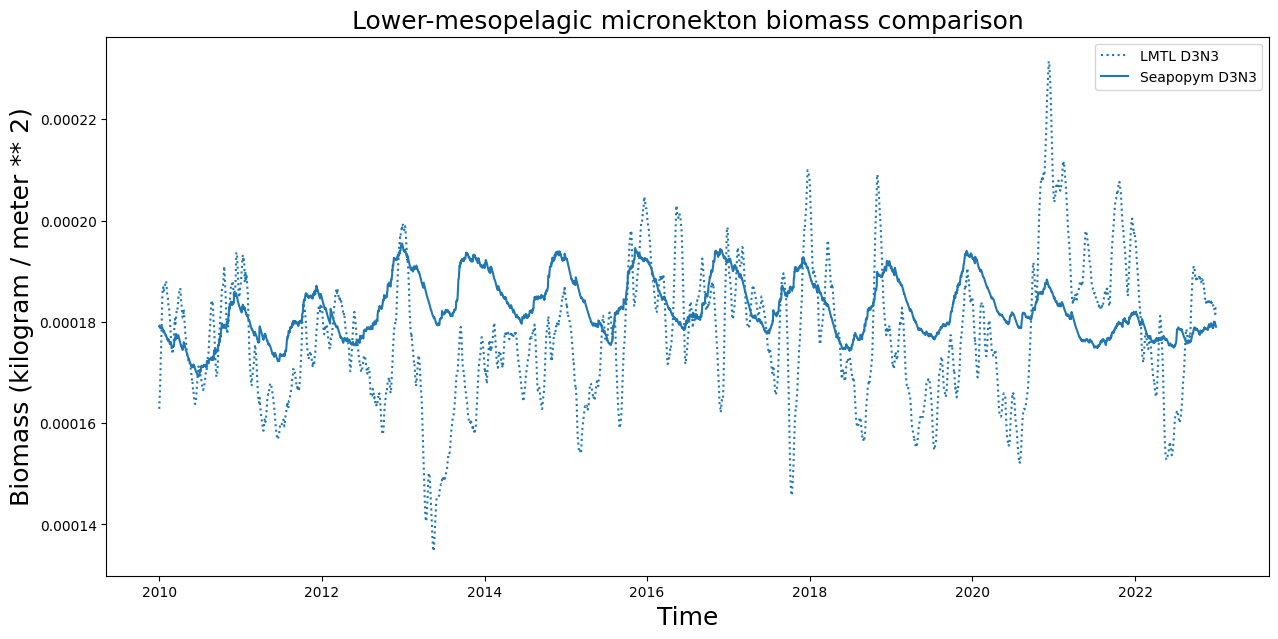

In [21]:
plt.figure(figsize=(15, 7))

color = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
lmtl_fg = ["mnkc_lmeso"]
seapopym_fg = ["lower_mesopelagic"]
names = ["D3N3"]
for i, name in enumerate(lmtl_fg):
    lmtl_mnk[name].plot.line(":", x="time", label=f"LMTL {names[i]}", color=color[i])

for i, name in enumerate(seapopym_fg):
    data = micronekton_model_with_initial_conditions.state.biomass.sel(functional_group=i).cf.mean(("X", "Y"))
    data.cf.plot.line(x="time", hue="functional_group", label=f"Seapopym {names[i]}", color=color[i])
plt.legend([i.data for i in micronekton_model_with_initial_conditions.state.name])

plt.legend()
plt.title("Lower-mesopelagic micronekton biomass comparison", fontsize=18)
plt.ylabel(f"Biomass ({StandardUnitsLabels.biomass.units})", fontsize=18)
plt.xlabel("Time", fontsize=18)
plt.show()